In [91]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error as MAE, r2_score as R2
from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import BaseCrossValidator

from sklearn.base import BaseEstimator
from typing import Union, Tuple
from xgboost import XGBRegressor
from pprint import pprint
from datetime import datetime
from joblib import dump
import math
from sklearn.model_selection import TimeSeriesSplit #si bien no son series de tiempo nuestros datos si presentan un problema con la similitud del train y test
import mlflow
from mlflow.tracking import MlflowClient


# Trackeo de experimentos
import mlflow
from mlflow.models import infer_signature
import dagshub

In [94]:
mlflow.sklearn.autolog()
dagshub.init(repo_owner='guillermovc', repo_name='MLOps-grinding', mlflow=True)



Initialized MLflow to track repo "guillermovc/MLOps-grinding"

Repository guillermovc/MLOps-grinding initialized!

In [33]:
processed_folder = Path.cwd().parent / 'data' / 'processed'
model_folder = Path.cwd().parent / 'models'
plt.style.use('ggplot')

In [148]:
df = pd.read_parquet(processed_folder / 'df_model_tidy.parquet')
df.head()

,date,velocidad,potencia,rendimiento,ruido,p80,f80,per_solidos,wi,spi,imp_criticos,imp_estandares,jb,presion
0,2022-11-15 00:07:50,75.761029,39281.348296,65.653747,22.932414,64.260113,36.574719,71.583049,94.815049,54.50695,7.101110,65.598165,9.183127,87.199926
1,2022-11-15 00:08:00,75.761029,39850.320731,65.691489,22.932414,64.260113,36.555098,71.579590,94.815049,54.50695,7.191338,65.798205,9.180693,87.402467
2,2022-11-15 00:08:10,75.761029,39761.319456,65.783858,21.329909,64.260113,36.535478,71.585002,94.815049,54.50695,7.281566,65.998244,9.178803,87.492231
3,2022-11-15 00:08:20,75.761029,39761.319456,65.906084,21.329909,64.260113,36.515857,71.598714,94.815049,54.50695,7.371795,66.198283,9.178803,87.492231
4,2022-11-15 00:08:30,75.761029,39665.960948,65.986245,22.538648,64.260113,36.583533,71.615886,94.815049,54.50695,7.462023,66.398322,9.174560,87.564041


# Pirmer intento

In [149]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train = df[df.date < datetime(2022, 12, 12)].drop(columns = ['presion', 'date', 'imp_estandares'])
y_train = df[df.date < datetime(2022, 12, 12)]['presion']

X_test = df[df.date >= datetime(2022, 12, 12)].drop(columns = ['presion', 'date', 'imp_estandares'])
y_test = df[df.date >= datetime(2022, 12, 12)]['presion']

In [150]:
X_test

,velocidad,potencia,rendimiento,ruido,p80,f80,per_solidos,wi,spi,imp_criticos,jb
223273,61.289289,32730.218758,45.547407,3.604423,30.482594,29.132077,74.074625,96.306752,40.677938,0.000000,86.330692
223274,61.231838,32730.218758,45.510341,3.604423,30.482594,29.060758,74.104980,96.306752,40.677938,0.000000,86.330692
223275,61.164822,31598.631123,45.475115,3.791207,30.482594,29.061834,74.140991,96.306752,40.677938,0.000000,86.327785
223276,61.097805,31541.416018,45.407662,3.791207,30.482594,29.062910,74.177002,96.306752,40.677938,0.000000,86.326418
223277,61.030789,32142.174622,45.358609,3.791207,30.482594,29.074935,74.213013,96.306752,40.677938,0.000000,86.325211
...,...,...,...,...,...,...,...,...,...,...,...
248668,75.494482,41194.875702,71.307249,8.845677,26.446656,45.849870,77.265464,92.573475,38.543220,0.900937,89.318678
248669,75.496079,41194.875702,71.403265,8.845677,26.446656,45.931528,77.298097,92.573475,38.543220,0.899591,89.318678
248670,75.497677,40686.296989,71.458539,8.845677,26.446656,46.134072,77.327109,92.573475,38.543220,0.898244,89.314536
248671,75.499274,40686.296989,71.513813,8.845677,26.446656,46.336617,77.356121,92.573475,38.543220,0.896897,89.314536


## Busqueda de parametros y entrenamiento

In [164]:
def search_params(
        estimator: XGBRegressor,
        params,
        X: np.ndarray, 
        y: np.ndarray, 
        X_new = None,
        y_new = None,
        random: bool = False, 
        n_iter: int = 100,
    ) -> Tuple[XGBRegressor, dict]:
    
    mlflow.set_experiment("XGBoost")
    
    with mlflow.start_run():
        for key, value in params.items():
            mlflow.log_param(key, value)

        # mlflow.log_params('variables entrenamiento', dict(zip(range(len(X_train.columns)), X_train.columns)))

        splitT = TimeSeriesSplit(n_splits = 5) #para combatir sobreajuste por similitud de datos en split usual, si se usa el normal es como si no se separaran

        if random:
            search = RandomizedSearchCV(estimator, params, cv=splitT, n_jobs=18, 
                                        scoring='neg_mean_squared_error', verbose=1, n_iter=n_iter)
        else:
            search = GridSearchCV(estimator, params, cv=splitT, n_jobs=18, 
                                  scoring='neg_mean_squared_error', verbose=1)

        search.fit(X, y)

        mlflow.log_metric("neg_mean_squared_error", -search.best_score_)

        best_params = search.best_params_
        best_model = search.best_estimator_

        #mae en datos no vistos
        if (X_new is None) or (y_new is None):
            pass
        else:
            y_new_hat = best_model.predict(X_new)
            mae_new = MAE(y_new, y_new_hat)

            mlflow.log_metric("mae datos no vistos", mae_new)
        
        mlflow.sklearn.log_model(best_model, "xgbboost_best")
        
        
    return best_model, best_params

In [165]:
# Definir los hiperparámetros para XGBoost
xgb_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.3, 0.5, 0.7],
    'reg_lambda':[1, 10, 100],
    'colsample_bytree': [0.5, 0.7]
}

# Llamar a la función con XGBRegressor y los parámetros definidos
xgbModel = XGBRegressor()

best_model, best_params = search_params(xgbModel, 
                                        xgb_params, 
                                        X_train, 
                                        y_train, 
                                        X_test,
                                        y_test,
                                        random=False)

# Imprimir el mejor modelo y los mejores parámetros
print(f"Mejor modelo: {best_model}")
print(f"Mejores parámetros: {best_params}")

Fitting 5 folds for each of 486 candidates, totalling 2430 fits


2024/06/01 23:45:42 INFO mlflow.sklearn.utils: Logging the 5 best runs, 481 runs will be omitted.


Mejor modelo: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)
Mejores parámetros: {'colsample_bytree': 0.5, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'reg_lambda': 100, 'subsample': 0.7}


## Evaluación modelo

In [166]:
#predicciones para test y para train
y_test_hat = best_model.predict(X_test)
y_train_hat = best_model.predict(X_train)

<Axes: title={'center': 'test data'}, ylabel='presion'>

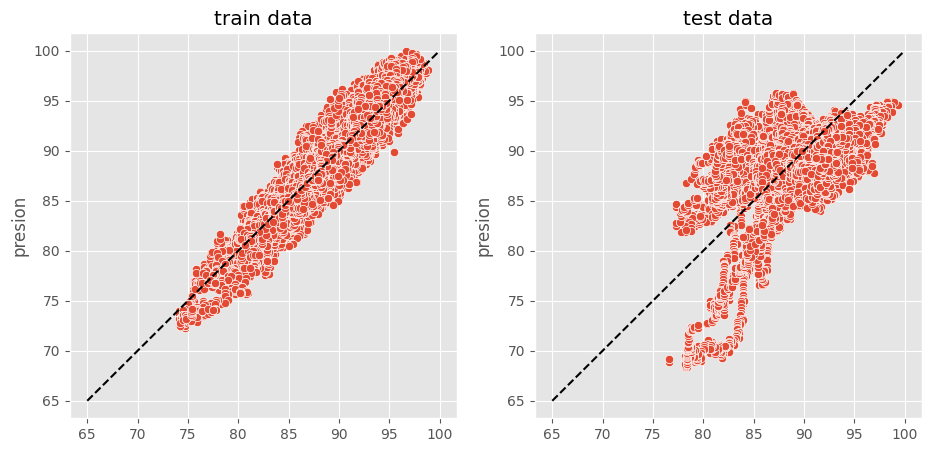

In [167]:
#vizualizacion variable predicha vs variable real
fig, axs = plt.subplots(1, 2, figsize = (11, 5))

axs[0].set_title('train data')
sns.scatterplot(x = y_train_hat, 
                y = y_train,
                ax = axs[0])

sns.lineplot(x= [65, 100],
            y = [65, 100],
            color = 'black',
            linestyle = '--',
            ax =axs[0])

axs[1].set_title('test data')
sns.scatterplot(x = y_test_hat, 
                y = y_test,
                ax = axs[1])

sns.lineplot(x= [65, 100],
            y = [65, 100],
            color = 'black',
            linestyle = '--',
            ax =axs[1])

In [168]:
mae_test = MAE(y_test, y_test_hat)
mae_train = MAE(y_train, y_train_hat)

print(f"error medio absoluto en train {mae_train:.2f}")
print(f"error medio absoluto en test {mae_test:.2f}")

error medio absoluto en train 0.83
error medio absoluto en test 2.93


## Visto desde la serie de tiempo

In [19]:
df['presion_hat'] = np.nan
df.loc[X_train.index, 'presion_hat'] = y_train_hat
df.loc[X_test.index, 'presion_hat'] = y_test_hat

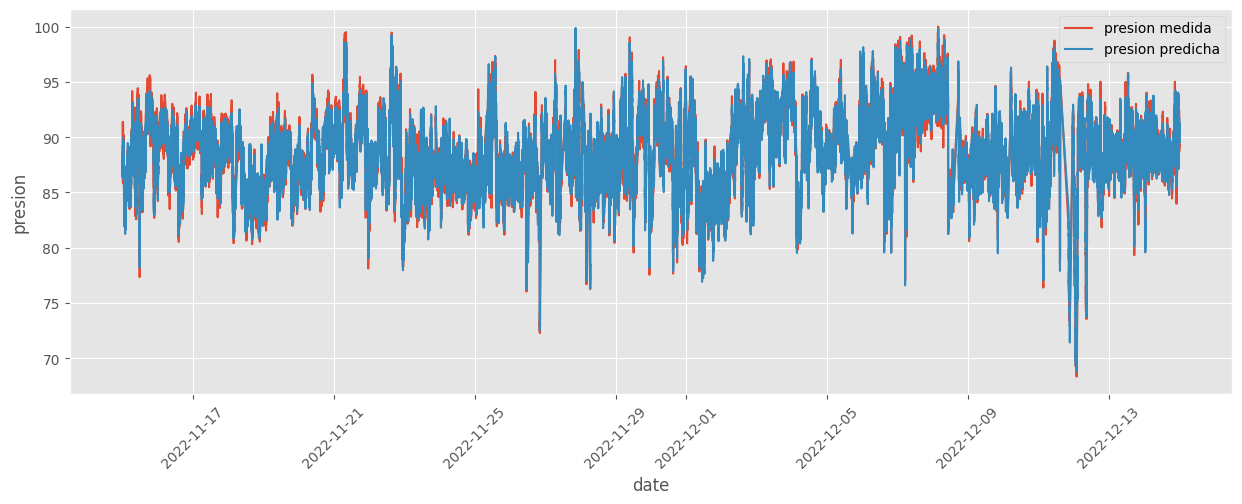

In [20]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(x = 'date',
            y = 'presion',
             data = df,
            label = 'presion medida')
sns.lineplot(x = 'date',
              y = 'presion_hat',
             data = df,
            label = 'presion predicha')
ax.tick_params(axis='x', rotation=45)

## Feature importance

In [20]:
feature_importances = best_model.named_steps['regressor'].feature_importances_
feature_names = X_train.columns

Text(0.5, 1.0, 'Feature Importance of XGBoost Model')

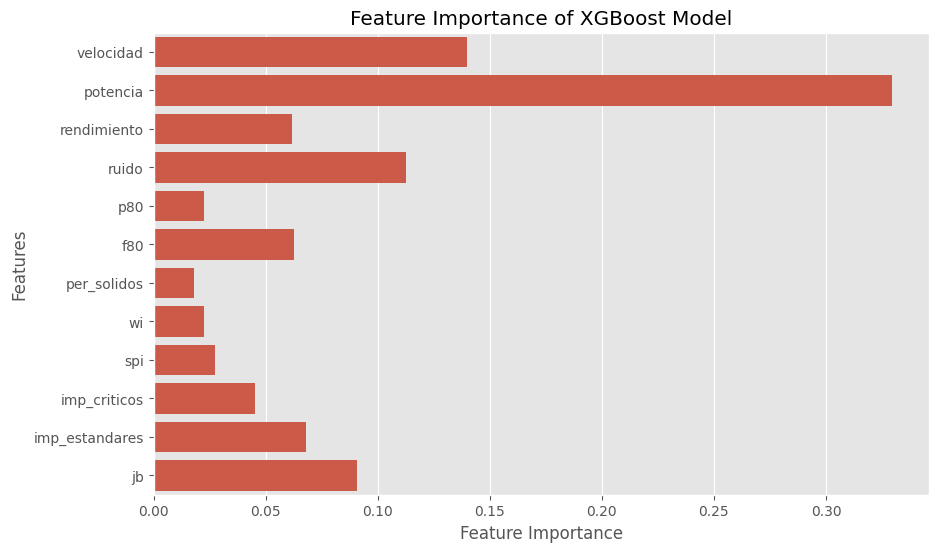

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=feature_importances, y=feature_names, ax=ax)


ax.set_xlabel('Feature Importance')
ax.set_ylabel('Features')
ax.set_title('Feature Importance of XGBoost Model')

# Segundo

Para evidtar overfiting en test y train por similutud extrema en datos de train y test, se reservan datos a partir del 12 de diciembre para asegurar que el modelo generaliza a condiciones no vistas yse usa un split de datos distintos.

In [103]:
df.columns

Index(['velocidad', 'potencia', 'ruido', 'rendimiento', 'f80', 'per_solidos',
       'date'],
      dtype='object')

## Busqueda de parametros y entrenamiento

Para generalizar mejor a datos no vistos de otras fechas, implementaremos cross-validation dejando huecos de datos intermedios. Esto implica dividir los datos en segmentos, omitiendo períodos específicos (por ejemplo, los primeros 5 días, del 5 al 10, del 15 al 20, etc.) para evaluar la capacidad del modelo para generalizar en situaciones o modos de trabajo no vistos.

In [170]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train = df[df.date < datetime(2022, 12, 12)].drop(columns = ['presion', 'date', 'imp_estandares'])
y_train = df[df.date < datetime(2022, 12, 12)]['presion']

X_test = df[df.date >= datetime(2022, 12, 12)].drop(columns = ['presion', 'date', 'imp_estandares'])
y_test = df[df.date >= datetime(2022, 12, 12)]['presion']

In [171]:
class CustomCrossValidator(BaseCrossValidator):
    """
    Generador de cross validation que deja intervalos intermedios como validacion.

    Parameters:
    - n_splits : int, default=5
        Number of splits (folds).
    """

    def __init__(self, n_splits=5):
        self.n_splits = n_splits

    def split(self, X, y=None, groups=None):
        """
            Separa a datos en base a ventaneos
        """
        n_samples = len(X)
        n_test = math.floor(n_samples / self.n_splits)

        for i in range(self.n_splits):
            start_test = i * n_test
            end_test = (i + 1) * n_test

            test_indices = range(start_test, end_test)
            train_indices = set(range(n_samples)) - set(test_indices)

            yield list(train_indices), list(test_indices)

    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits

In [172]:

# definimos la función que toma datos y devuelve los mejores parámetros

def search_params(
        estimator: BaseEstimator,
        params: dict,
        X: np.ndarray, 
        y: np.ndarray, 
        # window_size: int,
        # gap_size: int,
        name,
        random: bool = False, 
        n_iter: int = 100,
        
    ) -> Tuple[XGBRegressor, dict]:
    # Definir los parámetros para GridSearchCV

    print(f"Los parámetros para probar en nuestras pipelines son:")
    pprint(params)
    mlflow.set_experiment("XGBoost_2")
    
    # Creamos un pipeline con parámetros por defecto (serán sustituidos)
    with mlflow.start_run():
        for key, value in params.items():
            mlflow.log_param(key, value)
    
        cvC = CustomCrossValidator(n_splits=5) #dejar aprox 5 días
    
        if random:
            search = RandomizedSearchCV(estimator, params, cv=cvC, n_jobs=-2, 
                                        scoring='neg_mean_squared_error', verbose=1, n_iter=n_iter)
        else:
            search = GridSearchCV(estimator, params, cv=cvC, n_jobs=-2, 
                                  scoring='neg_mean_squared_error', verbose=1)
    
        search.fit(X, y)
    
        # Obtener los mejores hiperparámetros y el mejor modelo
        best_params = search.best_params_
        best_model = search.best_estimator_
    
        print(f"Los mejores parámetros de la busqueda: {best_params}")
        print(f"El mejor modelo de la busqueda: {best_model}")
        
        mlflow.log_metric("neg_mean_squared_error", -search.best_score_)
        
        mlflow.sklearn.log_model(best_model, name)
        

    return best_model, best_params

In [173]:
# Definir los hiperparámetros para XGBoost
xgb_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.3, 0.6],
    'reg_lambda':[10, 50, 100],
    'colsample_bytree': [0.5, 0.7]
}

# Llamar a la función con XGBRegressor y los parámetros definidos
model = XGBRegressor()
best_model, best_params = search_params(model, 
                                        xgb_params, 
                                        X_train, 
                                        y_train,
                                        'xgbboost_best_2',
                                        random=False)

# Imprimir el mejor modelo y los mejores parámetros
print(f"Mejor modelo: {best_model}")
print(f"Mejores parámetros: {best_params}")

Los parámetros para probar en nuestras pipelines son:
{'colsample_bytree': [0.5, 0.7],
 'learning_rate': [0.01, 0.05, 0.1],
 'max_depth': [3, 4, 5],
 'n_estimators': [50, 100, 200],
 'reg_lambda': [10, 50, 100],
 'subsample': [0.3, 0.6]}


2024/06/01 23:51:19 INFO mlflow.tracking.fluent: Experiment with name 'XGBoost_2' does not exist. Creating a new experiment.


Fitting 5 folds for each of 324 candidates, totalling 1620 fits


2024/06/01 23:54:54 INFO mlflow.sklearn.utils: Logging the 5 best runs, 319 runs will be omitted.


Los mejores parámetros de la busqueda: {'colsample_bytree': 0.5, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'reg_lambda': 100, 'subsample': 0.3}
El mejor modelo de la busqueda: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)
Mejor modelo: XGBRegressor(base_score=None, booster=None, callba

## Evaluación modelo

Text(0.5, 1.0, 'test tada')

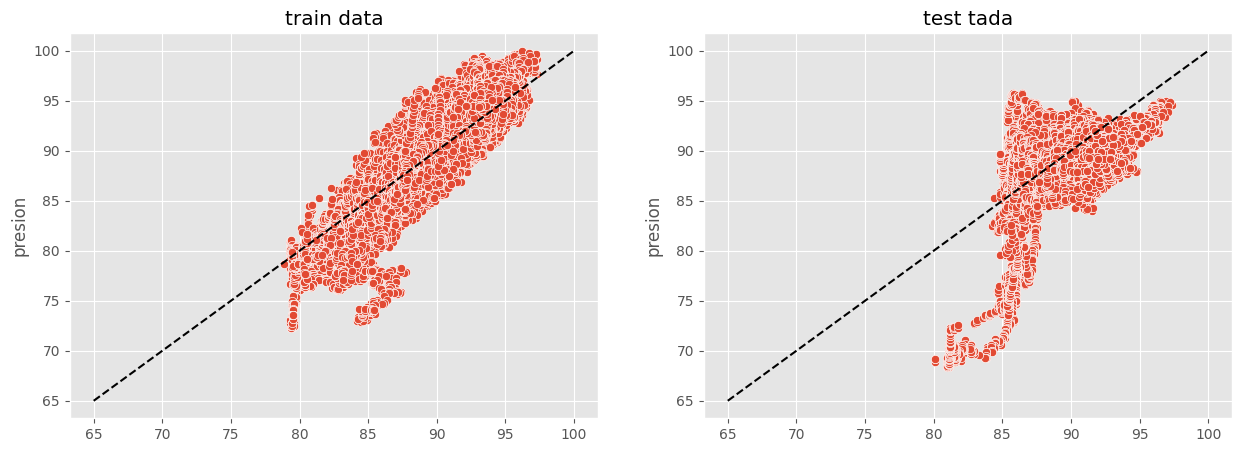

In [175]:
#predicciones para test y para train
y_train_hat = best_model.predict(X_train)
# y_train_hat = best_model.predict(X_train)
y_test_hat = best_model.predict(X_test)

#vizualizacion variable predicha vs variable real
fig, axs = plt.subplots(1, 2, figsize = (15, 5))

axs[0].set_title('train data')
sns.scatterplot(x = y_train_hat, 
                y = y_train,
                ax = axs[0])

sns.lineplot(x= [65, 100],
            y = [65, 100],
            color = 'black',
            linestyle = '--',
            ax =axs[0])


sns.scatterplot(x = y_test_hat, 
                y = y_test,
                ax = axs[1])

sns.lineplot(x= [65, 100],
            y = [65, 100],
            color = 'black',
            linestyle = '--',
            ax =axs[1])
axs[1].set_title('test tada')
# mae_test = MAE(y, y_hat)
# # mae_train = MAE(y_train, y_train_hat)
# mae_new = MAE(y_new, y_new_hat)

# print(f"error medio absoluto en train {mae_train:.2f}")
# # print(f"error medio absoluto en test {mae_test:.2f}")
# print(f"error medio absoluto en new {mae_new:.2f}")

In [176]:
mae_test = MAE(y_test, y_test_hat)
mae_train = MAE(y_train, y_train_hat)

print(f"error medio absoluto en train {mae_train:.2f}")
print(f"error medio absoluto en test {mae_test:.2f}")

error medio absoluto en train 1.13
error medio absoluto en test 2.31


In [177]:
df['presion_hat'] = np.nan

In [178]:
df.loc[X_train.index].shape

(223273, 15)

In [179]:
df.loc[X_train.index, 'presion_hat'] = y_train_hat
df.loc[X_test.index, 'presion_hat'] = y_test_hat

## Visto desde la serie de tiempo

Text(0.5, 1.0, 'datos antes del 12 de diciembre')

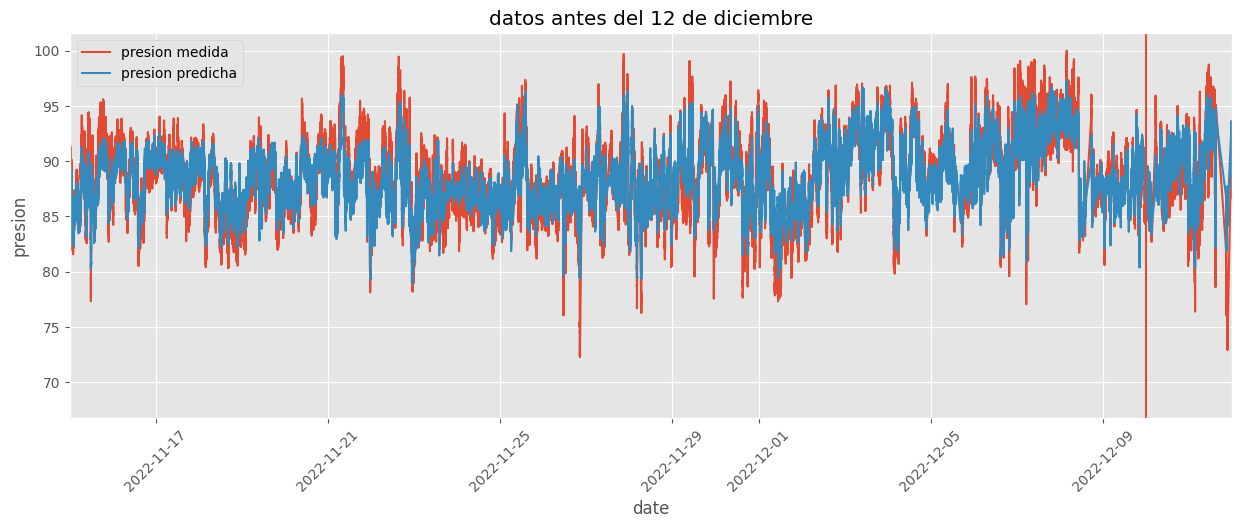

In [182]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(x = 'date',
            y = 'presion',
             data = df,
            label = 'presion medida')
sns.lineplot(x = 'date',
              y = 'presion_hat',
             data = df,
            label = 'presion predicha')
ax.tick_params(axis='x', rotation=45)

ax.set_xlim(datetime(2022, 11, 15), datetime(2022, 12, 12))
ax.axvline(datetime(2022,12, 10))
ax.set_title('datos antes del 12 de diciembre')

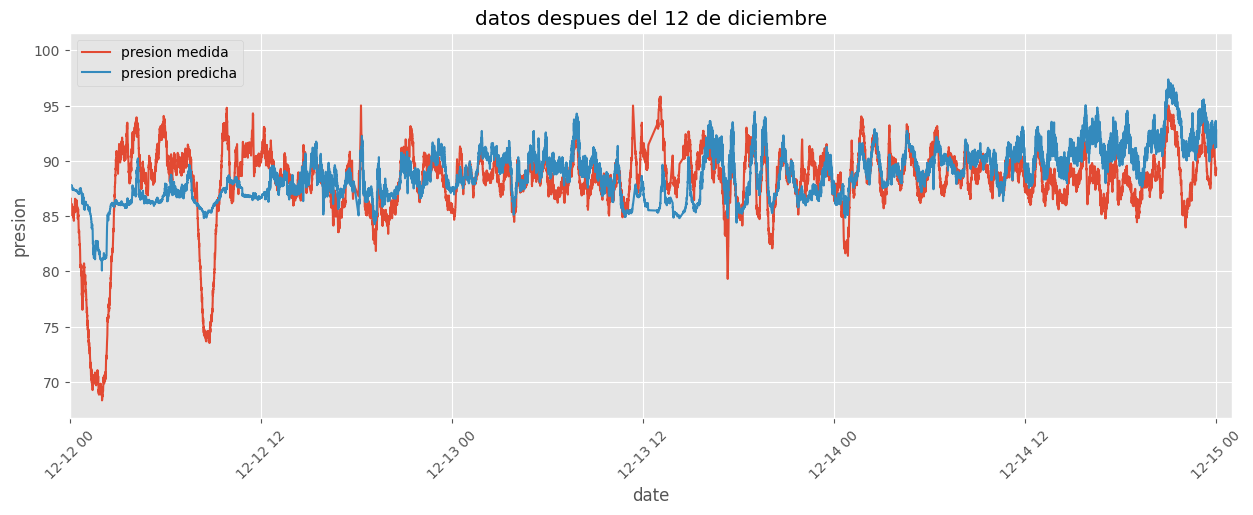

In [183]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(x = 'date',
            y = 'presion',
             data = df,
            label = 'presion medida')
sns.lineplot(x = 'date',
              y = 'presion_hat',
             data = df,
            label = 'presion predicha')
ax.tick_params(axis='x', rotation=45)

ax.set_title('datos despues del 12 de diciembre')
ax.set_xlim(datetime(2022, 12, 12), datetime(2022, 12, 15, 1))
ax.axvline(datetime(2022,12, 10))

## Feature importance

In [184]:
feature_importances = best_model.feature_importances_
feature_names = X_train.columns

Text(0.5, 1.0, 'Feature Importance of XGBoost Model')

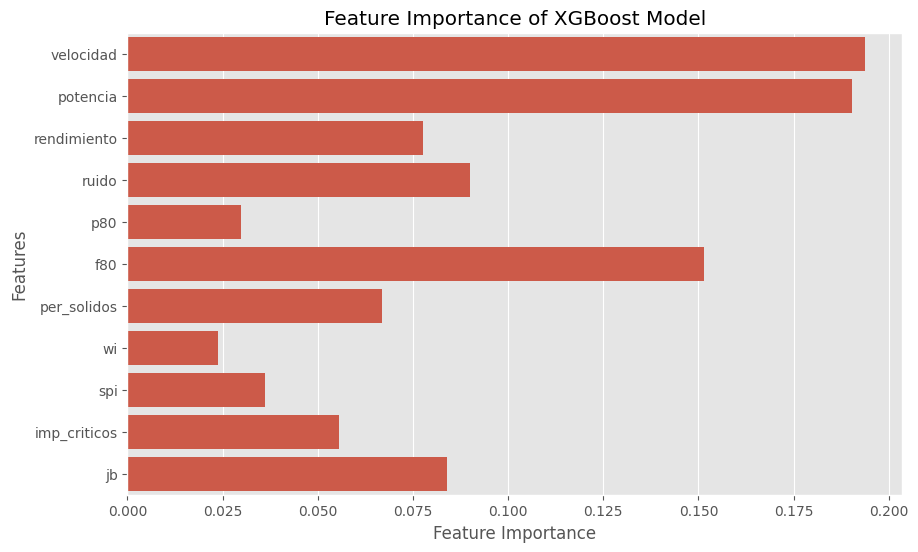

In [185]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=feature_importances, y=feature_names, ax=ax)


ax.set_xlabel('Feature Importance')
ax.set_ylabel('Features')
ax.set_title('Feature Importance of XGBoost Model')

# Concluso

La variable jb tiene un efecto muy significativo en la presión, pero este efecto no está siendo captado por el modelo. Esto podría deberse a que el nivel de bola en la banda, basado en un láser que cuenta el número de bolas, tiene un margen de error considerablemente alto. Si se contara con un jb con desviacion de a lo mas 3.125 (en la escala actual) se podrian obtener mejores resultados con xgboost.

Los resultados no son necesariamente negativos, pues podemos observar tendencias (las 2 caidas del 12 de diciembre) y podemos ver el efecto en sensores inteligentes como el f80 e impact finder. Lo que sí se observa es que conforme pasa el tiempo la predicción empeora y, al estar familiarizado con la operacion de molienda de este molino, intuimos que se debe a la desviacion de jb y al pequeño efecto del revestimiento.